# This Building Does Not Exist (Yet)

## AIASF _NEXT_ 2019
### Tyler Kvochick
### TEECOM Research & Development

# Goals

## Beyond Metaphors

What is a neural network, literally?

## Inner Workings

What makes a neural network...work?

## Applications

What interesting models exist today and what can we make them do?

# Setup

* Download a premade module for convenience
* Install a network visualization module
* Import libraries

In [2]:
!curl https://raw.githubusercontent.com/TEECOM/this-building-does-not-exist/master/ml/python/StyleGAN.py --output ./StyleGAN.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 22745  100 22745    0     0  82709      0 --:--:-- --:--:-- --:--:-- 82709


In [3]:
!pip install torchviz

     |████████████████████████████████| 51kB 12.2MB/s 
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz


In [0]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchviz import make_dot
from StyleGAN import Generator, Discriminator

# Beyond Metaphors

What does a neural network look like?

In [0]:
# Network visualization class
class NetworkVisualization(nn.Module):
    def __init__(self):
        super(NetworkVisualization, self).__init__()
        
        self.conv0 = nn.Conv2d(3, 6, (3, 3))
        self.act0 = nn.LeakyReLU()
        self.conv1 = nn.Conv2d(3, 6, (3, 3))
        self.act1 = nn.LeakyReLU()
    
    def forward(self, x):
        x0 = self.act0(self.conv0(x))
        x1 = self.act1(self.conv1(x))
        
        return x0 + x1

In [6]:
# Use our new class
nv = NetworkVisualization().cuda()

fake_image = torch.randn(1, 3, 512, 512).cuda()

out = nv(fake_image)

nv

NetworkVisualization(
  (conv0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (act0): LeakyReLU(negative_slope=0.01)
  (conv1): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
  (act1): LeakyReLU(negative_slope=0.01)
)

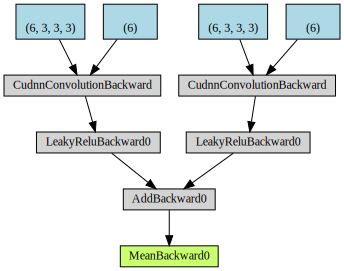

In [7]:
# Render the graph
make_dot(out.mean())

In [8]:
# Render the parameters
params = [p for p in list(nv.conv0.parameters())]
params

[Parameter containing:
 tensor([[[[-0.1742,  0.0613,  0.1837],
           [-0.0446, -0.1547,  0.1904],
           [-0.1783,  0.0812, -0.0872]],
 
          [[ 0.1405,  0.1764, -0.1429],
           [-0.1508,  0.0066, -0.0185],
           [-0.1792,  0.0979, -0.0402]],
 
          [[ 0.0126, -0.1502, -0.0445],
           [ 0.0542,  0.1348, -0.1392],
           [ 0.1450,  0.0954, -0.1487]]],
 
 
         [[[ 0.1273, -0.1273,  0.0328],
           [-0.1228,  0.0335, -0.0318],
           [-0.1132,  0.0948, -0.0937]],
 
          [[-0.1349,  0.1559, -0.1011],
           [-0.1635, -0.1710,  0.1274],
           [ 0.1068,  0.0563, -0.1405]],
 
          [[ 0.0166, -0.0707, -0.0190],
           [-0.0293, -0.1766, -0.0022],
           [-0.1628, -0.0686,  0.0811]]],
 
 
         [[[ 0.0816,  0.0444, -0.0336],
           [-0.1486,  0.0020,  0.1430],
           [-0.0005, -0.0450,  0.1371]],
 
          [[ 0.0171, -0.0725,  0.0576],
           [ 0.1089, -0.0450,  0.0125],
           [-0.0830,  0.0014, 

# No More Metaphors (Summary)

## Multiple Representations of NNs

1. As executable code / structured data (software)
2. As a connective graph (visualization)
3. As lists of numbers organized into rectilinear shapes (tensors)

---

# Inner Workings

We have seen that deep learning models are full of orthogonal collections of numbers that we call tensors. The rest of the model is made of mathematical functions for combining those tensors.

## Convolution

For working with images, the most common function for combining tensors in a learnable way is called convolution.

Convolution is a confusing name for "searching for known patterns".

To get a better intuitive understanding of what convolution is, we are going to look at a 1D example.

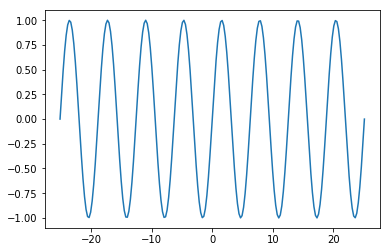

In [21]:
lim = 8 * np.pi
x_axis = np.linspace(-lim, lim, 200)
sin_x = np.sin(x_axis)

plt.plot(x_axis, sin_x)

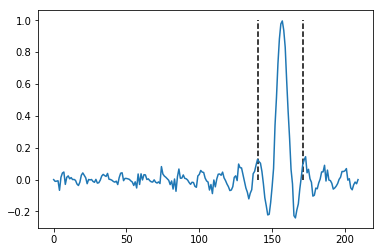

In [42]:
# Put special_signal in an external file

def special_signal():
    low = -12 * np.pi
    high = 4 * np.pi
    
    space_s = np.linspace(2 * low, 2 * high, 210)
    space = np.linspace(-8 * np.pi, 8 * np.pi, 210)
    
    noise = np.random.randn(space.size) * 0.03
    
    event = np.sin(space_s) / space_s
    
    base_signal = np.sin(space) * noise
    
    return base_signal + event
    
ss = special_signal()

plt.plot(ss)
plt.vlines([140, 171], -0, 1, linestyles="--")

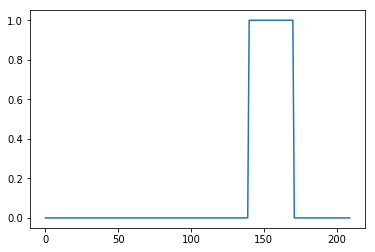

In [41]:
label = np.zeros_like(ss)
label[140:171] = 1.0

plt.plot(label)

In [44]:
a = np.arange(0, 10)
print(a)
print(a[2:5])

[0 1 2 3 4 5 6 7 8 9]
[2 3 4]


In [0]:
# Define convolution from scratch

def convolve(signal, kernel, stride=1):
    sw = signal.shape[0]
    kw = kernel.shape[0]
    
    n_positions = sw // stride
    step_size = sw // n_positions

    out = []
    
    input_slices = []
    
    for i in range(n_positions):
        start_idx = i * step_size
        
        this_slice = signal[start_idx:start_idx + kw]
        
        tsw = this_slice.shape[0]
        
        # Ensure that our output is the same shape as our kernel
        this_slice = np.pad(this_slice, (0, kw - tsw), 'constant')
        
        input_slices += [this_slice]

        product = this_slice * kernel
        
        out += [np.sum(product)]

    return np.array(out), np.stack(input_slices)
        

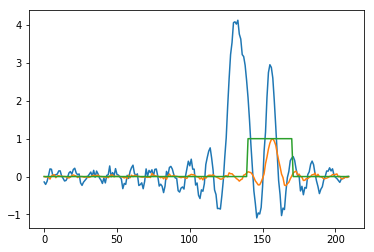

In [98]:
# Examine one step of applying convolution

kernel = np.random.randn(30)

output, input_slices = convolve(ss, kernel, stride=1)

plt.plot(output)
plt.plot(ss)
plt.plot(label)

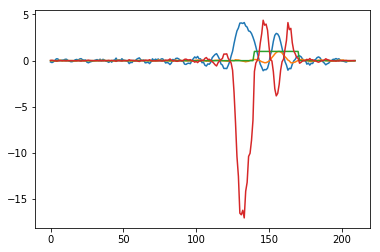

In [100]:
# Define a loss function
def squared_error(output, target):
    error = target - output
    sq_error = (error ** 3) / np.abs(error)
    return sq_error

se = squared_error(output, label)
plt.plot(output)
plt.plot(ss)
plt.plot(label)
plt.plot(se)

## Things Required to Make Machines Learn

1. Input
2. Label

(Dataset)

3. Function to transform Input -> Label
4. Function to measure how far off the output is

(Model)

5. A way to update kernel based on how far off the output is

(Backpropagation, i.e. derivatives)

$$ O(\mathbf{I}) = \mathbf{I} \cdot \mathbf{k} $$
$$\frac{\delta O}{\delta \mathbf{k}} = \mathbf{I} $$


In [135]:
# Apply our convolution function to learn about our event

kernel = np.random.randn(30)
learning_rate = 0.0005
losses = []

for n in range(1000):
    output, input_slices = convolve(ss, kernel)
    
    se = squared_error(output, label)
    
    loss = se.mean()
    
    losses += [loss]
    
    if n % 10 == 0:
        print("Mean Squared Error Loss: {:.4f}".format(loss))
    
    # Manual backpropagation
    for (error, in_slice) in zip(se, input_slices):
        kernel_update = error * in_slice * learning_rate
        kernel = kernel + kernel_update
    
losses = np.array(losses)       

Mean Squared Error Loss: 0.7215
Mean Squared Error Loss: 0.2704
Mean Squared Error Loss: 0.1667
Mean Squared Error Loss: 0.1255
Mean Squared Error Loss: 0.1044
Mean Squared Error Loss: 0.0920
Mean Squared Error Loss: 0.0840
Mean Squared Error Loss: 0.0785
Mean Squared Error Loss: 0.0744
Mean Squared Error Loss: 0.0713
Mean Squared Error Loss: 0.0689
Mean Squared Error Loss: 0.0669
Mean Squared Error Loss: 0.0653
Mean Squared Error Loss: 0.0639
Mean Squared Error Loss: 0.0627
Mean Squared Error Loss: 0.0616
Mean Squared Error Loss: 0.0607
Mean Squared Error Loss: 0.0599
Mean Squared Error Loss: 0.0591
Mean Squared Error Loss: 0.0585
Mean Squared Error Loss: 0.0578
Mean Squared Error Loss: 0.0573
Mean Squared Error Loss: 0.0567
Mean Squared Error Loss: 0.0563
Mean Squared Error Loss: 0.0558
Mean Squared Error Loss: 0.0554
Mean Squared Error Loss: 0.0550
Mean Squared Error Loss: 0.0546
Mean Squared Error Loss: 0.0543
Mean Squared Error Loss: 0.0539
Mean Squared Error Loss: 0.0536
Mean Squ

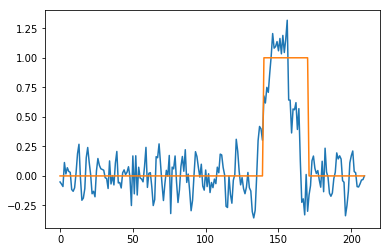

In [136]:
# Plot output and label

plt.plot(output)
plt.plot(label)

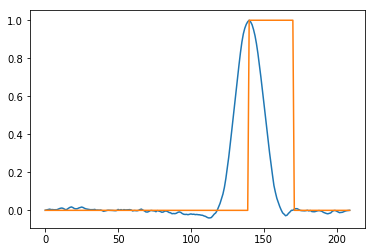

In [163]:
def gaussian_kernel(mu=0, sigma=1, width=30):
    x = np.linspace(-sigma, 2 * sigma, width)
    exp = np.e ** (-1 * (x - mu) ** 2)/(2 * sigma ** 2)
    
    return (1 / (sigma * np.sqrt(2 * np.pi))) * exp

smooth, _ = convolve(output, gaussian_kernel())
plt.plot(smooth / smooth.max())
plt.plot(label)

array([ 1.19663691,  0.61837706,  0.71739128, -0.53494237, -0.99623686,
       -2.4865975 ,  1.15299923,  1.09748925,  3.41378121, -0.12536123,
       -0.99650617, -0.04560978, -0.09850861, -0.42558539, -0.62278903,
       -0.35544655,  1.0004429 ,  0.96057434,  0.20721645,  0.29359558,
        0.26367147, -0.26253689, -0.04372914, -1.23167512,  0.61960067,
       -1.46658917,  0.5269658 ,  1.52322538,  0.39852265, -1.09309095])

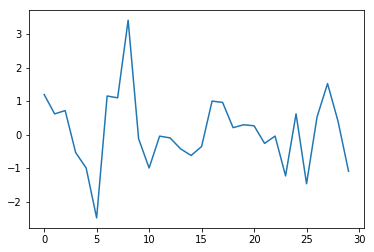

In [137]:
# Plot and print kernel

plt.plot(kernel)
kernel

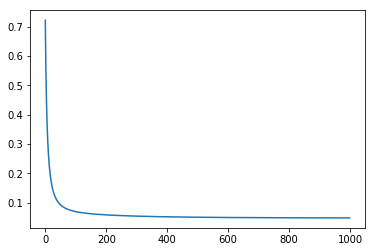

In [138]:
# Plot loss over time

plt.plot(losses)

# How does it work (Summary)

Neural networks use (fairly) simple mathematical functions to discover non-obvious solutions.
These are not found by describing complex rules, but merely by describing relationships between inputs and desired outputs.

We can use ideas from calculus and linear algebra to start from random values that transform from input to output and steer the output towards better and better results.